**Experiments**

1)Baseline model(the given one): Val acc: 73.44, kaggle score:65.88 <br>
2)Pretrained Resnet18 (without augmentation) Val acc: 82, Kaggle score: 84.335 <br>
3)Pretrained Resnet18 (with augmentation) + 2 trained layers from above. Val acc: 79.19 <br>
4)Pretrained Resnet18 (with augmentation) + 2 trainable layers from scratch. Val acc: 79.52 <br>
5)Pretrained Resnet101 (without augmentation) Val acc: 86.30, kaggle score: **85.898** <br>
6)Pretrained Resnet101 (without augmentation) on train and val data, kaggle score: **86.102** <br>

I have lost few outputs while finetuning on same code again and again. Few are having **training progress in curves**. All the experiments lie in this notebook. <br>
with baseline model I didn't spend much time as transfer learning was in the hand. <br>
With resnet18 I tried 3 optimizers, at most time Adam was powerful in initial epochs but lost grip in getting higher accuracy. Between RMSprop and SGD, SGD had a slight lead over another. In early epochs, SGD + momentum was giving better curve. <br>
Augmentation unexpectadly did not help much. I tried 4 to 5 augmentations all together and few alone but not much improvement on validation and kaggle score. <br>
Other small experiments included gradient clipping, more linear, batchnorm, activation layers behind resnet.

In [1]:
%matplotlib inline  
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader,sampler,Dataset
import torchvision.datasets as dset
import torchvision.transforms as T
import timeit
from PIL import Image
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import torchvision.models as models
from IPython.display import clear_output

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

In [3]:
# cd '/content/gdrive/My Drive/ML/hw6/again/Question2/'

In [4]:
# import os, os.path
# # path joining version for other paths
# DIR = './data/trainClips/'
# print(len([name for name in os.listdir(DIR) if not os.path.isfile(os.path.join(DIR, name))]))

In [5]:
import gc
def clean():
    gc.collect()
    torch.cuda.empty_cache()

In [6]:
label_mat=scipy.io.loadmat('./data/q3_2_data.mat')
label_train=label_mat['trLb']
print(len(label_train))
label_val=label_mat['valLb']
print(len(label_val))
class ActionDataset(Dataset):
    """Action dataset."""

    def __init__(self,  root_dir,labels=[], transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            labels(list): labels if images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.length=len(os.listdir(self.root_dir))
        self.labels=labels
    def __len__(self):
        return self.length*3

    def __getitem__(self, idx):
        
        folder=int(idx/3)+1
        imidx=idx%3+1
        folder=format(folder,'05d')
        imgname=str(imidx)+'.jpg'
        img_path = os.path.join(self.root_dir,
                                folder,imgname)
        image = Image.open(img_path)
        if len(self.labels)!=0:
            Label=self.labels[int(idx/3)][0]-1
        if self.transform:
            image = self.transform(image)
        if len(self.labels)!=0:
            sample={'image':image,'img_path':img_path,'Label':Label}
        else:
            sample={'image':image,'img_path':img_path}
        return sample
dtype = torch.cuda.FloatTensor
print_every = 100
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()      
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image 
# image_dataset_train=ActionDataset(root_dir='./data/trainClips/',labels=label_train,transform=T.ToTensor())

# image_dataloader_train = DataLoader(image_dataset_train, batch_size=32,
#                         shuffle=True, num_workers=0)
# image_dataset_val=ActionDataset(root_dir='./data/valClips/',labels=label_val,transform=T.ToTensor())

# image_dataloader_val = DataLoader(image_dataset_val, batch_size=32,
#                         shuffle=False, num_workers=0)
# image_dataset_test=ActionDataset(root_dir='./data/testClips/',labels=[],transform=T.ToTensor())

# image_dataloader_test = DataLoader(image_dataset_test, batch_size=32,
#                         shuffle=False, num_workers=0)

7770
2230


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train(model, loss_fn, optimizer, dataloader, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, sample in enumerate(dataloader):
            x_var = Variable(sample['image'])
            y_var = Variable(sample['Label'].long())
            
            model = model.to(device)
            x_var, y_var = x_var.to(device), y_var.to(device)
            
            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        check_accuracy(model, image_dataloader_val)
def check_accuracy(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for t, sample in enumerate(loader):
        x_var = Variable(sample['image'])
        y_var = sample['Label']
        
        model = model.to(device)
        x_var, y_var = x_var.to(device), y_var.to(device)
            
        #y_var=y_var.cpu()
        scores = model(x_var)
        _, preds = scores.data.max(1)#scores.data.cpu().max(1)
        #print(preds)
        #print(y_var)
        num_correct += (preds.cpu().numpy() == y_var.cpu().numpy()).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [8]:
fixed_model_base = nn.Sequential( 
    nn.Conv2d(3, 8, kernel_size=7, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(8, 16, kernel_size=7, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    Flatten(),
    nn.ReLU(),
    nn.Linear(16*11*11, 10)
            )
fixed_model = fixed_model_base.type(dtype)

optimizer = torch.optim.RMSprop(fixed_model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss().type(dtype)


In [9]:
def check_accuracy_2d(model, loader, pretrained=None):
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(loader):
        if t+1 % 1100==0:
            print('wait')
        x_var = Variable(sample['image'].type(dtype))
        y_var = sample['Label'].type(dtype)
        model = model.type(dtype)
        y_var=y_var.cpu()
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds.numpy() == y_var.numpy()).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc * 100

In [10]:
def predict_on_test(model, loader, pretrained = None):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    results=open('results.csv','w')
    count=0
    results.write('Id'+','+'Class'+'\n')
    for t, sample in enumerate(loader):
        x_var = Variable(sample['image']).cuda()
        if pretrained:
          x_var = pretrained(x_var)
        scores = model(x_var)
        _, preds = scores.data.max(1)
        for i in range(len(preds)):
            results.write(str(count)+','+str(int(preds[i]))+'\n')
            count+=1
    results.close()
    return count

1) Baseline using given model in assignment

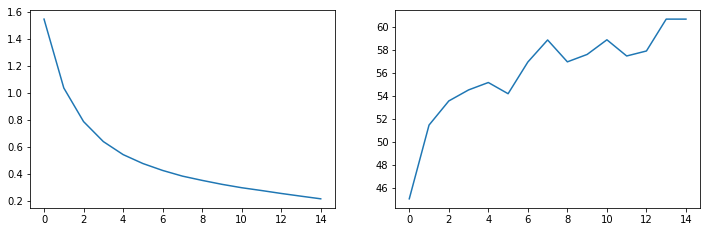

Epoch 15 =>  Val acc: 60.64275037369208


In [11]:
train_tf = T.Compose([
    T.ToTensor()
])
val_tf = T.Compose([
    T.ToTensor()
])

image_dataset_train=ActionDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

image_dataloader_train = DataLoader(image_dataset_train, batch_size=32,
                        shuffle=True, num_workers=0)
image_dataset_val=ActionDataset(root_dir='./data/valClips/',labels=label_val,transform=val_tf)

image_dataloader_val = DataLoader(image_dataset_val, batch_size=32,
                        shuffle=False, num_workers=0)

model = fixed_model_base
pretrained = None
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss().type(dtype)

num_epochs = 15
train_losses = []
val_losses = []
val_accs = []
best_acc = 0
PATH = 'saved_models/2d_{}.pt'
dtype = torch.cuda.FloatTensor
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(image_dataloader_train):
        model.train()

        x_var = sample['image'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 100 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
    
    del x_var, y_var, scores
    acc = check_accuracy_2d(model, image_dataloader_val, pretrained=pretrained)

    val_losses.append(np.mean(np.array(losses)))
    
    val_accs.append(acc)
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
        plt.subplot(222)
        plt.plot(val_accs)
        plt.show()
        print("Epoch", epoch+1, "=> ", "Val acc:", acc)

2) Used pretrained model - resnet18, <br>
Changed optimizer to SGD with learning rate 1e-5 and momentum 0.09, <br>
Used normalisation and size given for resnet, <br>
Reduced batch size to 24, 

In [ ]:
pretrained = models.resnet18(pretrained=True)
pretrained.eval()

model = nn.Sequential(
    nn.Linear(1000, 1000),
    nn.ReLU(inplace=True),
    nn.Linear(1000, 10)
)

optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum = 0.09)
loss_fn = nn.CrossEntropyLoss().type(dtype)

train_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset_train=ActionDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

image_dataloader_train = DataLoader(image_dataset_train, batch_size=4,
                        shuffle=True, num_workers=0)
image_dataset_val=ActionDataset(root_dir='./data/valClips/',labels=label_val,transform=val_tf)

image_dataloader_val = DataLoader(image_dataset_val, batch_size=4,
                        shuffle=False, num_workers=0)

num_epochs = 15
train_losses = []
val_losses = []
val_accs = []
best_acc = 80
PATH = 'saved_models/2dpretrained_{}.pt'
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(image_dataloader_train):
        model.train()

        x_var = sample['image'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 250 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
    
    del x_var, y_var, scores
    acc = check_accuracy_2d(model, image_dataloader_val, pretrained=pretrained)

    val_losses.append(np.mean(np.array(losses)))
    
    val_accs.append(acc)
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
        plt.subplot(222)
        plt.plot(val_accs)
        plt.show()
        print("Epoch", epoch+1, "=> ", "Val acc:", acc)
    if acc > best_acc:
        best_acc = acc
        torch.save(model, PATH.format(str(acc)[:5]))

5) resnet 101 Val acc: 86.30, **kaggle score: 85.898**

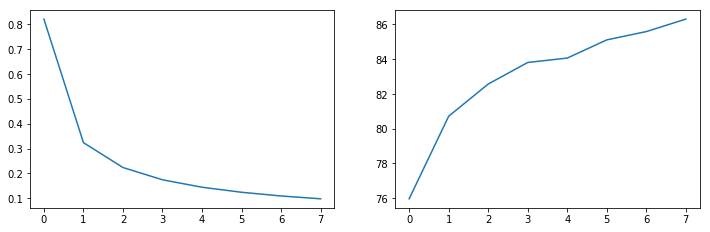

Epoch 8 =>  Val acc: 86.30792227204783


KeyboardInterrupt: 

In [11]:
pretrained = models.resnet101(pretrained=True)
pretrained.eval()

model = nn.Sequential(
    nn.Linear(1000, 1000),
    nn.ReLU(inplace=True),
    nn.Linear(1000, 10)
)

optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum = 0.09)
loss_fn = nn.CrossEntropyLoss().type(dtype)

train_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset_train=ActionDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

image_dataloader_train = DataLoader(image_dataset_train, batch_size=4,
                        shuffle=True, num_workers=0)
image_dataset_val=ActionDataset(root_dir='./data/valClips/',labels=label_val,transform=val_tf)

image_dataloader_val = DataLoader(image_dataset_val, batch_size=4,
                        shuffle=False, num_workers=0)

num_epochs = 15
train_losses = []
val_losses = []
val_accs = []
best_acc = 80
PATH = 'saved_models/2dpretrained_{}.pt'
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(image_dataloader_train):
        model.train()

        x_var = sample['image'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 250 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
    
    del x_var, y_var, scores
    acc = check_accuracy_2d(model, image_dataloader_val, pretrained=pretrained)

    val_losses.append(np.mean(np.array(losses)))
    
    val_accs.append(acc)
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
        plt.subplot(222)
        plt.plot(val_accs)
        plt.show()
        print("Epoch", epoch+1, "=> ", "Val acc:", acc)
    if acc > best_acc:
        best_acc = acc
        torch.save(model, PATH.format(str(acc)[:5]))

continuing, increased batch size to 8

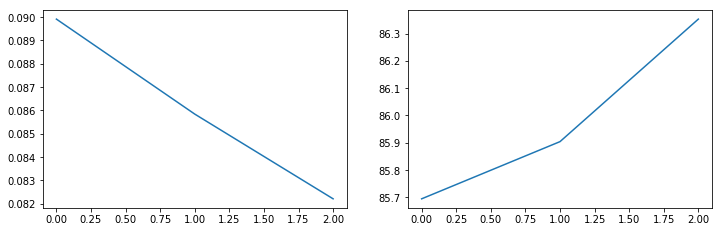

Epoch 11 =>  Val acc: 86.35276532137519


KeyboardInterrupt: 

In [14]:
pretrained = models.resnet101(pretrained=True)
pretrained.eval()

model = torch.load('saved_models/2dpretrained_86.30.pt')

optimizer = optim.SGD(model.parameters(), lr=0.5*1e-4, momentum = 0.09)
loss_fn = nn.CrossEntropyLoss().type(dtype)

train_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset_train=ActionDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

image_dataloader_train = DataLoader(image_dataset_train, batch_size=4,
                        shuffle=True, num_workers=0)
image_dataset_val=ActionDataset(root_dir='./data/valClips/',labels=label_val,transform=val_tf)

image_dataloader_val = DataLoader(image_dataset_val, batch_size=4,
                        shuffle=False, num_workers=0)

num_epochs = 15
train_losses = []
val_losses = []
val_accs = []
best_acc = 80
PATH = 'saved_models/2dpretrained_{}.pt'
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(image_dataloader_train):
        model.train()

        x_var = sample['image'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 250 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
    
    del x_var, y_var, scores
    acc = check_accuracy_2d(model, image_dataloader_val, pretrained=pretrained)

    val_losses.append(np.mean(np.array(losses)))
    
    val_accs.append(acc)
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
        plt.subplot(222)
        plt.plot(val_accs)
        plt.show()
        print("Epoch", epoch+9, "=> ", "Val acc:", acc)
    if acc > best_acc:
        best_acc = acc
        torch.save(model, PATH.format(str(acc)[:5]))

**train = train + val**

**Kaggle score:0.86102**

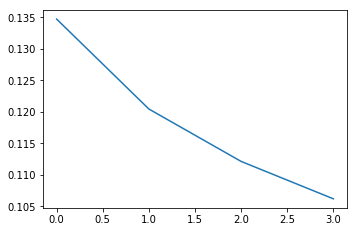

Epoch 4 =>  Train Loss: 0.106


KeyboardInterrupt: 

In [16]:
pretrained = models.resnet101(pretrained=True)
pretrained.eval()

optimizer = optim.SGD(model.parameters(), lr=0.5*1e-4, momentum = 0.09)
loss_fn = nn.CrossEntropyLoss().type(dtype)

train_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset_train=ActionDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

image_dataloader_train = DataLoader(image_dataset_train, batch_size=4,
                        shuffle=True, num_workers=0)
image_dataset_val=ActionDataset(root_dir='./data/valClips/',labels=label_val,transform=val_tf)

image_dataloader_val = DataLoader(image_dataset_val, batch_size=4,
                        shuffle=False, num_workers=0)

merged = torch.utils.data.ConcatDataset([image_dataset_train, image_dataset_val])

image_dataloader_trainMega = DataLoader(merged, batch_size=10,
                        shuffle=True, num_workers=0)

num_epochs = 5
train_losses = []
# val_losses = []
# val_accs = []
# best_acc = 80
PATH = 'saved_models/2dM_{}.pt'
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(image_dataloader_trainMega):
        model.train()

        x_var = sample['image'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 1000 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    del x_var, y_var, scores
    train_losses.append(np.mean(np.array(losses)))

    torch.save(model, PATH.format(str(epoch+1)))
        
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
        plt.show()
        print("Epoch", epoch+1, "=> ", "Train Loss:", str(train_losses[-1])[:5])

In [ ]:
pretrained = models.resnet101(pretrained=True)
pretrained.eval()

optimizer = optim.SGD(model.parameters(), lr=0.5*1e-4, momentum = 0.09)
loss_fn = nn.CrossEntropyLoss().type(dtype)
model = torch.load('saved_models/2dM_4.pt')
train_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset_train=ActionDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

image_dataloader_train = DataLoader(image_dataset_train, batch_size=4,
                        shuffle=True, num_workers=0)
image_dataset_val=ActionDataset(root_dir='./data/valClips/',labels=label_val,transform=val_tf)

# image_dataloader_val = DataLoader(image_dataset_val, batch_size=4,
#                         shuffle=False, num_workers=0)

merged = torch.utils.data.ConcatDataset([image_dataset_train, image_dataset_val])

image_dataloader_trainMega = DataLoader(merged, batch_size=10,
                        shuffle=True, num_workers=0)

num_epochs = 5
train_losses = []
# val_losses = []
# val_accs = []
# best_acc = 80
PATH = 'saved_models/2dM_{}.pt'
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(image_dataloader_trainMega):
        model.train()

        x_var = sample['image'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 1000 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    del x_var, y_var, scores
    train_losses.append(np.mean(np.array(losses)))

    torch.save(model, PATH.format(str(epoch+1)))
        
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
        plt.show()
        print("Epoch", epoch+5, "=> ", "Train Loss:", str(train_losses[-1])[:5])

t = 1000, loss = 0.0346


In [19]:
val_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset_test=ActionDataset(root_dir='./data/testClips/',labels=[],transform=val_tf)

image_dataloader_test = DataLoader(image_dataset_test, batch_size=8,
                        shuffle=False, num_workers=0)


pretrained = models.resnet101(pretrained=True)
pretrained.eval()

# model = torch.load('saved_models/2dpretrained_86.35.pt')
model = torch.load('saved_models/2dM_4.pt')
# model = torch.load('saved_models/2dM_3.pt')


model = model.type(torch.cuda.FloatTensor)
pretrained = pretrained.type(torch.cuda.FloatTensor)

predict_on_test(model, image_dataloader_test, pretrained = pretrained)

9810

In [21]:
clean()

Finetuning pretrained resnet18 <br> replaced last layer with my layer and kept all layers trainable.

In [ ]:
pretrained = models.resnet18(pretrained=True)
pretrained.eval()

model = pretrained
model.fc = nn.Linear(model.fc.in_features, 10)
pretrained = None

optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum = 0.09)
loss_fn = nn.CrossEntropyLoss().type(dtype)

train_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset_train=ActionDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

image_dataloader_train = DataLoader(image_dataset_train, batch_size=4,
                        shuffle=True, num_workers=0)
image_dataset_val=ActionDataset(root_dir='./data/valClips/',labels=label_val,transform=val_tf)

image_dataloader_val = DataLoader(image_dataset_val, batch_size=4,
                        shuffle=False, num_workers=0)

num_epochs = 15
train_losses = []
val_losses = []
val_accs = []
best_acc = 80
PATH = 'saved_models/2dpretrained_{}.pt'
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(image_dataloader_train):
        model.train()

        x_var = sample['image'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 250 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
    
    del x_var, y_var, scores
    acc = check_accuracy_2d(model, image_dataloader_val, pretrained=pretrained)

    val_losses.append(np.mean(np.array(losses)))
    
    val_accs.append(acc)
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
        plt.subplot(222)
        plt.plot(val_accs)
        plt.show()
        print("Epoch", epoch+1, "=> ", "Val acc:", acc)
    if acc > best_acc:
        best_acc = acc
        torch.save(model, PATH.format(str(acc)[:5]))

3) From the trained model with a resnet, loaded best val acc model and added image augmentation to improve performance further

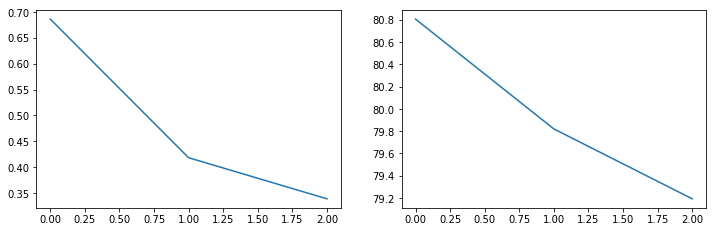

Epoch 3 =>  Val acc: 79.19282511210763


KeyboardInterrupt: 

In [17]:
pretrained = models.resnet18(pretrained=True)
pretrained.eval()
model = nn.Sequential(
    nn.Linear(1000, 1000),
    nn.ReLU(inplace=True),
    nn.Linear(1000, 10)
)

model = torch.load('best_model_0.8878923766816144.pt')

optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum = 0.09)
loss_fn = nn.CrossEntropyLoss().type(dtype)

train_tf = T.Compose([
    T.Resize(224),
    T.RandomOrder([
        T.RandomVerticalFlip(p=0.8),
        T.RandomPerspective()
    ]),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset_train=ActionDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

image_dataloader_train = DataLoader(image_dataset_train, batch_size=24,
                        shuffle=True, num_workers=0)
image_dataset_val=ActionDataset(root_dir='./data/valClips/',labels=label_val,transform=val_tf)

image_dataloader_val = DataLoader(image_dataset_val, batch_size=24,
                        shuffle=False, num_workers=0)

num_epochs = 15
train_losses = []
val_losses = []
val_accs = []
best_acc = 82.59
PATH = 'saved_models/2dpretrained_{}.pt'
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(image_dataloader_train):
        model.train()

        x_var = sample['image'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 100 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
    
    del x_var, y_var, scores
    acc = check_accuracy_2d(model, image_dataloader_val, pretrained=pretrained)

    val_losses.append(np.mean(np.array(losses)))
    
    val_accs.append(acc)
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
        plt.subplot(222)
        plt.plot(val_accs)
        plt.show()
        print("Epoch", epoch+1, "=> ", "Val acc:", acc)
    if acc > best_acc:
        best_acc = acc
        torch.save(model, PATH.format(str(acc)[:5]))

Kept image augmentation and trained model from scratch with pretrained resnet 18

In [ ]:
pretrained = models.resnet18(pretrained=True)
pretrained.eval()

model = nn.Sequential(
    nn.Linear(1000, 1000),
    nn.ReLU(inplace=True),
    nn.Linear(1000, 10)
)

train_tf = T.Compose([
    T.Resize(224),
    T.RandomOrder([
        T.RandomVerticalFlip(p=0.8),
        T.RandomRotation(45),
        T.RandomPerspective()
    ]),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset_train=ActionDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

image_dataloader_train = DataLoader(image_dataset_train, batch_size=24,
                        shuffle=True, num_workers=0)
image_dataset_val=ActionDataset(root_dir='./data/valClips/',labels=label_val,transform=val_tf)

image_dataloader_val = DataLoader(image_dataset_val, batch_size=24,
                        shuffle=False, num_workers=0)

num_epochs = 10
train_losses = []
val_losses = []
val_accs = []
best_acc = 88.59
PATH = 'saved_models/2dpretrained_{}.pt'

optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum = 0.09)
loss_fn = nn.CrossEntropyLoss().type(dtype)

for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(image_dataloader_train):
        model.train()

        x_var = sample['image'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 100 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
    
    del x_var, y_var, scores
    acc = check_accuracy_2d(model, image_dataloader_val, pretrained=pretrained)

    val_losses.append(np.mean(np.array(losses)))
    
    val_accs.append(acc)
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
        plt.subplot(222)
        plt.plot(val_accs)
        plt.show()
        print("Epoch", epoch+1, "=> ", "Val acc:", acc)
    if acc > best_acc:
        best_acc = acc
        torch.save(model, PATH.format(str(acc)[:5]))

4) image augmentation, after pretrained model added 2 linear layers

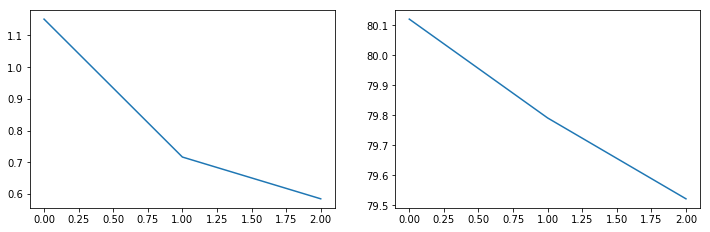

Epoch 3 =>  Val acc: 79.52167414050822
t = 100, loss = 0.7827
t = 200, loss = 0.3766
t = 300, loss = 0.7191
t = 400, loss = 0.7609
t = 500, loss = 0.5935
t = 600, loss = 0.6033
t = 700, loss = 0.4108
t = 800, loss = 0.8593


KeyboardInterrupt: 

In [57]:
pretrained = models.resnet18(pretrained=True)
pretrained.eval()

model = nn.Sequential(
    nn.Linear(1000, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 10)
)

train_tf = T.Compose([
    T.Resize(224),
    T.RandomOrder([
        T.RandomVerticalFlip(p=0.8),
        T.RandomRotation(45),
        T.RandomPerspective()
    ]),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset_train=ActionDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

image_dataloader_train = DataLoader(image_dataset_train, batch_size=24,
                        shuffle=True, num_workers=0)
image_dataset_val=ActionDataset(root_dir='./data/valClips/',labels=label_val,transform=val_tf)

image_dataloader_val = DataLoader(image_dataset_val, batch_size=24,
                        shuffle=False, num_workers=0)

num_epochs = 15
train_losses = []
val_losses = []
val_accs = []
best_acc = 88.59
PATH = 'saved_models/2dpretrained_{}.pt'

optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum = 0.09, weight_decay = 0.01)
loss_fn = nn.CrossEntropyLoss().type(dtype)

for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(image_dataloader_train):
        model.train()

        x_var = sample['image'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 100 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
    
    del x_var, y_var, scores
    acc = check_accuracy_2d(model, image_dataloader_val, pretrained=pretrained)

    val_losses.append(np.mean(np.array(losses)))
    
    val_accs.append(acc)
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
        plt.subplot(222)
        plt.plot(val_accs)
        plt.show()
        print("Epoch", epoch+1, "=> ", "Val acc:", acc)
    if acc > best_acc:
        best_acc = acc
        torch.save(model, PATH.format(str(acc)[:5]))

Val/Test

In [32]:
val_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset_test=ActionDataset(root_dir='./data/testClips/',labels=[],transform=val_tf)

image_dataloader_test = DataLoader(image_dataset_test, batch_size=32,
                        shuffle=False, num_workers=0)


image_dataset_val=ActionDataset(root_dir='./data/valClips/',labels=label_val,transform=val_tf)

image_dataloader_val = DataLoader(image_dataset_val, batch_size=24,
                        shuffle=False, num_workers=0)
pretrained = models.resnet18(pretrained=True)
pretrained.eval()

model = torch.load('best_model_0.8962630792227205.pt')
model = model.type(torch.cuda.FloatTensor)
pretrained = pretrained.type(torch.cuda.FloatTensor)
# acc = check_accuracy_2d(model, image_dataloader_val, pretrained=pretrained)
predict_on_test(model, image_dataloader_test, pretrained)

9810